In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader, Dataset
from torchvision.transforms import ToTensor
import torchvision.transforms as tt
from torchvision.datasets import ImageFolder
from torchvision.utils import make_grid
from torchvision import transforms, utils, datasets, models
from torch.autograd import Variable
from torchvision.utils import make_grid
from torch.utils.data import random_split, ConcatDataset
import torchvision.transforms as tt
from keras.optimizers import Adam
import torch.backends.cudnn as cudnn
import torch.optim
import glob
import os
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import random
from PIL import Image
from sklearn.metrics import confusion_matrix
%matplotlib inline


In [ ]:
def merge_trainval_test(filepath):
    merge_dir = os.path.dirname(os.path.abspath(f'{filepath}/annotations/data.txt'))
    df = pd.read_csv(f"{filepath}/annotations/trainval.txt", sep=" ", names=["Image", "ID", "SPECIES", "BREED ID"])
    df2 = pd.read_csv(f"{filepath}/annotations/test.txt", sep=" ",names=["Image", "ID", "SPECIES", "BREED ID"])
    frame = [df, df2]
    df = pd.concat(frame)
    df.reset_index(drop=True)
    df.to_csv(f'{filepath}/annotations/data.txt', index=None, sep=' ')


In [ ]:
dataset_directory = os.path.join("./dataset")
filepath = os.path.join(dataset_directory)
merge_trainval_test(filepath)

In [ ]:
dataset = pd.read_csv(f"{filepath}/annotations/data.txt", sep=" ")
dataset

,Image,ID,SPECIES,BREED ID
0,Abyssinian_100,1,1,1
1,Abyssinian_101,1,1,1
2,Abyssinian_102,1,1,1
3,Abyssinian_103,1,1,1
4,Abyssinian_104,1,1,1
...,...,...,...,...
7344,yorkshire_terrier_96,37,2,25
7345,yorkshire_terrier_97,37,2,25
7346,yorkshire_terrier_98,37,2,25
7347,yorkshire_terrier_99,37,2,25


In [ ]:
image_ids = []
labels = []
with open(f"{filepath}/annotations/trainval.txt") as file:
    for line in file:
        image_id, label, *_ = line.strip().split()
        image_ids.append(image_id)
        labels.append(int(label)-1)

classes = [
    " ".join(part.title() for part in raw_cls.split("_"))
    for raw_cls, _ in sorted(
        {(image_id.rsplit("_", 1)[0], label) for image_id, label in zip(image_ids, labels)},
        key=lambda image_id_and_label: image_id_and_label[1],
    )
    ]

idx_to_class = dict(zip(range(len(classes)), classes))

In [ ]:
idx_to_class


{0: 'Abyssinian',
 1: 'American Bulldog',
 2: 'American Pit Bull Terrier',
 3: 'Basset Hound',
 4: 'Beagle',
 5: 'Bengal',
 6: 'Birman',
 7: 'Bombay',
 8: 'Boxer',
 9: 'British Shorthair',
 10: 'Chihuahua',
 11: 'Egyptian Mau',
 12: 'English Cocker Spaniel',
 13: 'English Setter',
 14: 'German Shorthaired',
 15: 'Great Pyrenees',
 16: 'Havanese',
 17: 'Japanese Chin',
 18: 'Keeshond',
 19: 'Leonberger',
 20: 'Maine Coon',
 21: 'Miniature Pinscher',
 22: 'Newfoundland',
 23: 'Persian',
 24: 'Pomeranian',
 25: 'Pug',
 26: 'Ragdoll',
 27: 'Russian Blue',
 28: 'Saint Bernard',
 29: 'Samoyed',
 30: 'Scottish Terrier',
 31: 'Shiba Inu',
 32: 'Siamese',
 33: 'Sphynx',
 34: 'Staffordshire Bull Terrier',
 35: 'Wheaten Terrier',
 36: 'Yorkshire Terrier'}

In [ ]:
dataset['nID'] = dataset['ID'] - 1


In [ ]:
decode_map = idx_to_class
def decode_label(label):
    return decode_map[int(label)]
dataset["class"] = dataset["nID"].apply(lambda x: decode_label(x))


In [ ]:
dataset

,Image,ID,SPECIES,BREED ID,nID,class
0,Abyssinian_100,1,1,1,0,Abyssinian
1,Abyssinian_101,1,1,1,0,Abyssinian
2,Abyssinian_102,1,1,1,0,Abyssinian
3,Abyssinian_103,1,1,1,0,Abyssinian
4,Abyssinian_104,1,1,1,0,Abyssinian
...,...,...,...,...,...,...
7344,yorkshire_terrier_96,37,2,25,36,Yorkshire Terrier
7345,yorkshire_terrier_97,37,2,25,36,Yorkshire Terrier
7346,yorkshire_terrier_98,37,2,25,36,Yorkshire Terrier
7347,yorkshire_terrier_99,37,2,25,36,Yorkshire Terrier


In [ ]:
dataset['class'].value_counts()


Yorkshire Terrier             200
Samoyed                       200
Russian Blue                  200
Ragdoll                       200
Pug                           200
Pomeranian                    200
Persian                       200
Miniature Pinscher            200
Maine Coon                    200
Leonberger                    200
American Bulldog              200
Japanese Chin                 200
Havanese                      200
Great Pyrenees                200
German Shorthaired            200
English Setter                200
Shiba Inu                     200
Chihuahua                     200
British Shorthair             200
Sphynx                        200
Wheaten Terrier               200
Birman                        200
Bengal                        200
Beagle                        200
Basset Hound                  200
American Pit Bull Terrier     200
Saint Bernard                 200
Siamese                       199
Scottish Terrier              199
Keeshond      

In [ ]:
len(dataset[dataset['SPECIES']==2])
# 25 dog species image count in all dataset.

4978

In [ ]:
dog_species=dataset["class"][dataset[dataset["SPECIES"]==2].index].unique()

In [ ]:
len(dog_species)
  

25

In [ ]:
dog_species=dog_species[:15]
dog_species

array(['American Bulldog', 'American Pit Bull Terrier', 'Basset Hound',
       'Beagle', 'Boxer', 'Chihuahua', 'English Cocker Spaniel',
       'English Setter', 'German Shorthaired', 'Great Pyrenees',
       'Havanese', 'Japanese Chin', 'Keeshond', 'Leonberger',
       'Miniature Pinscher'], dtype=object)

In [ ]:
dog_dataset = dataset[dataset['class'].isin(dog_species)]

In [ ]:
dog_dataset

,Image,ID,SPECIES,BREED ID,nID,class
50,american_bulldog_100,2,2,1,1,American Bulldog
51,american_bulldog_101,2,2,1,1,American Bulldog
52,american_bulldog_102,2,2,1,1,American Bulldog
53,american_bulldog_103,2,2,1,1,American Bulldog
54,american_bulldog_104,2,2,1,1,American Bulldog
...,...,...,...,...,...,...
5856,miniature_pinscher_96,22,2,15,21,Miniature Pinscher
5857,miniature_pinscher_97,22,2,15,21,Miniature Pinscher
5858,miniature_pinscher_98,22,2,15,21,Miniature Pinscher
5859,miniature_pinscher_99,22,2,15,21,Miniature Pinscher


In [ ]:
dog_dataset.to_csv("new_dog_dataset.csv",index=False)

#Saving the dataset containing the names of dogs that I will use in training as csv.

In [11]:
cd C:\Users\Melike.Colak\Desktop\HACETTEPE\computervision\assignment\dataset

C:\Users\Melike.Colak\Desktop\HACETTEPE\computervision\assignment\dataset


In [12]:
ls

 Volume in drive C is Windows
 Volume Serial Number is 3C28-09FD

 Directory of C:\Users\Melike.Colak\Desktop\HACETTEPE\computervision\assignment\dataset

06/10/2023  03:04 AM    <DIR>          .
06/10/2023  03:04 AM    <DIR>          ..
06/30/2012  01:45 PM    <DIR>          annotations
06/02/2023  09:03 AM        44,813,069 cnn_0.0001.pth
06/02/2023  09:09 AM    <DIR>          cnn-0.0001
06/03/2023  01:55 AM    <DIR>          cnn-0.001
06/18/2012  07:54 PM    <DIR>          images
06/01/2023  03:14 AM           123,537 new_dog_dataset.csv
06/03/2023  02:56 AM    <DIR>          resnet
               2 File(s)     44,936,606 bytes
               7 Dir(s)  239,972,741,120 bytes free


In [3]:
import torch
import pandas as pd
from torchvision.datasets.folder import default_loader
from torch.utils.data import Dataset
from torchvision.transforms import ToTensor, Resize, Compose

class CustomDataset(Dataset):
    def __init__(self, csv_file, root_dir):
        self.data = pd.read_csv(csv_file)
        self.root_dir = root_dir
        self.classes = sorted(self.data['class'].unique())  
        self.class_to_index = {c: i for i, c in enumerate(self.classes)}  
        
        self.transform = Compose([
            torchvision.transforms.Resize((100,100)),
#             torchvision.transforms.RandomHorizontalFlip(),  # Flip augmentation
            torchvision.transforms.ToTensor(),
            torchvision.transforms.Normalize(mean=[0.5,0.5,0.5], std=[0.5,0.5,0.5]), 
        ])
    def __len__(self):
        return len(self.data)

    def __getitem__(self, index):
        img_name = os.path.join(self.root_dir, str(self.data.iloc[index, 0]) + ".jpg")
        image = default_loader(img_name)
        image = self.transform(image) 

        label = self.data.iloc[index, 4]


        return image,label


csv_file = "new_dog_dataset.csv"  
root_dir = "images"
dataset = CustomDataset(csv_file, root_dir)



In [78]:
from torchvision import datasets, transforms
import torch
from torch.utils.data import DataLoader, ConcatDataset


class AugmentedDataset(Dataset):
    def __init__(self, csv_file, root_dir):
        self.data = pd.read_csv(csv_file)
        self.root_dir = root_dir
        self.classes = sorted(self.data['class'].unique()) 
        self.class_to_index = {c: i for i, c in enumerate(self.classes)}  
        
        self.transform = Compose([
            torchvision.transforms.Resize((100,100)),
            torchvision.transforms.RandomHorizontalFlip(),
            torchvision.transforms.ToTensor(),
            torchvision.transforms.Normalize(mean=[0.5,0.5,0.5], std=[0.5,0.5,0.5]), 

        ])
    def __len__(self):
        return len(self.data)

    def __getitem__(self, index):
        img_name = os.path.join(self.root_dir, str(self.data.iloc[index, 0]) + ".jpg")
        image = default_loader(img_name)
        image = self.transform(image) 
        label = self.data.iloc[index, 4]

        return image,label

csv_file = "new_dog_dataset.csv"
root_dir = "images" 
augmented_dataset = AugmentedDataset(csv_file, root_dir)



combined_dataset = ConcatDataset([dataset, augmented_dataset])



In [11]:
len(combined_dataset) 
#veri kümesi 2 katına çıktı.

5988

In [4]:
BATCH_SIZE=256
#data
train_count = int(0.7 * len(dataset)) 
valid_count = int(0.2 * len(dataset))
test_count = len(dataset) - train_count - valid_count

train_dataset, valid_dataset, test_dataset = torch.utils.data.random_split(dataset, (train_count, valid_count, test_count))
train_dataset_loader = torch.utils.data.DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)  
valid_dataset_loader = torch.utils.data.DataLoader(valid_dataset, batch_size=BATCH_SIZE, shuffle=True) 
test_dataset_loader  = torch.utils.data.DataLoader(test_dataset , batch_size=BATCH_SIZE, shuffle=False)
dataloaders = {'train': train_dataset_loader, 'val': valid_dataset_loader, 'test': test_dataset_loader}

In [79]:
BATCH_SIZE=256
#augmented data 

aug_train_count = int(0.7 * len(combined_dataset)) 
aug_valid_count = int(0.2 * len(combined_dataset))
aug_test_count = len(combined_dataset) - aug_train_count - aug_valid_count

aug_train_dataset, aug_valid_dataset, aug_test_dataset = torch.utils.data.random_split(combined_dataset, (aug_train_count, aug_valid_count, aug_test_count))
aug_train_dataset_loader = torch.utils.data.DataLoader(aug_train_dataset, batch_size=BATCH_SIZE, shuffle=True)  
aug_valid_dataset_loader = torch.utils.data.DataLoader(aug_valid_dataset, batch_size=BATCH_SIZE, shuffle=True) 
aug_test_dataset_loader  = torch.utils.data.DataLoader(aug_test_dataset , batch_size=BATCH_SIZE, shuffle=False)
aug_dataloaders = {'train': aug_train_dataset_loader, 'val': aug_valid_dataset_loader, 'test': aug_test_dataset_loader}

In [80]:
print("Train count: ", aug_train_count)
print("Test count: ", aug_valid_count)
print("Validation count: ", aug_test_count)

Train count:  4191
Test count:  1197
Validation count:  600


In [5]:
#dropout eklenmiş model
import torch.nn.functional as F

class MyModel(nn.Module):
    def __init__(self, number_of_classes):
        super().__init__()
        
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=12, padding=1, kernel_size=3)
        self.bn1 = nn.BatchNorm2d(num_features=12)
        self.relu1 = nn.ReLU()
        self.pool1 = nn.MaxPool2d(kernel_size=2)
        
        self.conv2 = nn.Conv2d(in_channels=12, out_channels=20, padding=1, kernel_size=3)
        self.bn2 = nn.BatchNorm2d(num_features=20)
        self.relu2 = nn.ReLU()
        
        self.conv3 = nn.Conv2d(in_channels=20, out_channels=32, padding=1, kernel_size=3)
        self.bn3 = nn.BatchNorm2d(num_features=32)
        self.relu3 = nn.ReLU()
        self.pool3 = nn.MaxPool2d(kernel_size=2)
        
        self.fc1 = nn.Linear(32 * 25 * 25, 15) ## My  images are 100 x 100 pixel. 
        self.dropout = nn.Dropout(0.25) 

    def forward(self, Input):
        output = self.conv1(Input)
        output = self.bn1(output)
        output = self.relu1(output)
        output = self.pool1(output)
        
        output = self.conv2(output)
        output = self.bn2(output)
        output = self.relu2(output)
        
        output = self.conv3(output)
        output = self.bn3(output)
        output = self.relu3(output)
        output = self.pool3(output)
        
        output = torch.flatten(output, 1)
        output = output.view(-1, 32 * 25 * 25) 
        output = self.fc1(output)
        output = self.dropout(output) 

        
        return output
    



Architecture Detail:

The first convolutional layer conv1 uses 3 input channels (which would be suitable for an RGB image), 
outputs 12 channels, uses a 3x3 kernel size, and 1 padding. After this convolution operation, 
a Batch Normalization bn1 is applied with 12 features. This is followed by a ReLU activation function
relu1 to add non-linearity to the model, and finally a MaxPooling operation pool1 with a 2x2 kernel size
is used to reduce the spatial dimensions of the output.

The second convolutional layer conv2 has 12 input channels (matching the output channels of the first layer),
outputs 20 channels, uses a 3x3 kernel size, and has a padding of 1. This is followed by Batch Normalization 
bn2 with 20 features, a ReLU activation function relu2.

The third convolutional layer conv3 takes 20 input channels (matching the output channels of the second layer),
outputs 32 channels, uses a 3x3 kernel size, and has a padding of 1. This is followed by Batch Normalization bn3
with 32 features, a ReLU activation function relu3, and a MaxPooling operation pool3 with a 2x2 kernel size.

The output of the third convolutional layer is flattened and input into the fully connected layer fc1 which 
has an output size of 15. After this, a Dropout layer is applied with a dropout probability of 0.25.


I choosed ReLU as activation function because, it is a popular activation function in deep learning due to 
its computational efficiency and effectiveness in adding non-linearity to the model. It helps the model learn 
from complex, real-world data, and overcomes the vanishing gradient problem that hampers learning in other
activation functions. ReLU also promotes sparse activation, meaning only a subset of neurons are activated,
making the network more efficient.
However, it's not always the perfect choice and may sometimes be replaced by its variants to overcome certain 
issues like the "dying ReLU" problem. Maybe i could try Leakly relu. 
Maybe i can try Leaky ReLU or Parametric ReLU next time for this reason. 

I've chosen to use the Cross-Entropy Loss for our task, which is a common choice for multi-class classification problems.
The Cross-Entropy Loss is particularly suitable when the outputs of the neural network are probabilities. 
The function calculates the performance of a classification model whose output is a probability value between 0 and 1.
As the predicted probability diverges from the actual label, the loss increases, effectively encouraging my model to 
output probabilities closer to the true labels.

For the optimization algorithms, I have experimented with both Stochastic Gradient Descent (SGD) and 
Adam (Adaptive Moment Estimation). SGD is robust and reliable but can be slower and require more hyperparameter tuning.
Adam, on the other hand, often provides quicker convergence and requires less hyperparameter tuning, as it adaptively
changes its learning rate based on recent gradients. By comparing these two methods on our specific tasks and datasets,
I hope to gain practical insights into which one is more suitable for our particular problem.

In [49]:
#These are my helper functions.


def plot_loss_acc(train_loss_values,valid_loss_values,train_acc_values,valid_acc_values):

    plt.figure()
    plt.plot(train_loss_values, label='Train Loss')
    plt.plot(valid_loss_values, label='Valid Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()

    plt.figure()
    plt.plot(train_acc_values, label='Train Accuracy')
    plt.plot(valid_acc_values, label='Valid Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.show()
    
def find_most_misclassified_class(confusion_mat, classes):
    misclassified_counts = confusion_mat.sum(axis=1) - np.diagonal(confusion_mat)
    most_misclassified_index = np.argmax(misclassified_counts)
    most_misclassified_class = classes[most_misclassified_index]
    print("Most Misclassified Class:", most_misclassified_class)
    return most_misclassified_class

def create_confmatrix(model,test_dataset_loader):
    model.eval()
    all_predictions = []
    all_labels = []

    with torch.no_grad():
        for images, labels in test_dataset_loader:
            images = images.to(device)
            labels = labels.to(device)

            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)

            all_predictions.extend(predicted.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    confusion_mat = confusion_matrix(all_labels, all_predictions)
    class_names = train_dataset.dataset.classes

    find_most_misclassified_class(confusion_mat, class_names)
    
    accuracy = np.diagonal(confusion_mat).sum() / confusion_mat.sum()
    FP = confusion_mat.sum(axis=0) - np.diagonal(confusion_mat)
    FN = confusion_mat.sum(axis=1) - np.diagonal(confusion_mat)
    TP = np.diagonal(confusion_mat)
    TN = confusion_mat.sum() - (FP + FN + TP)

    print("Accuracy:", accuracy)
    print("False Positive:", FP)
    print("False Negative:", FN)
    print("True Positive:", TP)
    print("True Negative:", TN)
    plt.figure(figsize=(10, 8))
    sns.heatmap(confusion_mat, annot=True, fmt="d", cmap="Blues")
    plt.xlabel("Predicted Labels")
    plt.ylabel("True Labels")
    plt.title("Confusion Matrix")
    plt.show()


In [17]:
# My training function which inputs train test and validation data.
# Also, number of epoch, patience for early stopping mechanism and the model. 

def fit_to_model(train_dataset_loader, valid_dataset_loader,test_dataset_loader, epochs,optimizer, Loss, model, patience):
    loss_fn = Loss
    optimizer = optimizer
    scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.1) 
    best_val_loss = float('inf')
    patience_counter = 0    
    
    train_loss_values = []
    train_acc_values = []
    valid_loss_values = []
    valid_acc_values = []

    for epoch in range(epochs):
        model.train()
        running_loss = 0.0
        correct_train = 0
        total_train = 0

        for images, labels in train_dataset_loader:
            images = images.to(device)
            labels = labels.to(device)
            optimizer.zero_grad()

            outputs = model(images)
            loss = loss_fn(outputs, labels)

            loss.backward()
            optimizer.step()

            running_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total_train += labels.size(0)
            correct_train += (predicted == labels).sum().item()

        scheduler.step() 

        epoch_loss = running_loss / len(train_dataset_loader)
        epoch_train_acc = correct_train / total_train

        train_loss_values.append(epoch_loss)
        train_acc_values.append(epoch_train_acc)

        model.eval()
        valid_loss = 0.0
        correct_valid = 0
        total_valid = 0

        with torch.no_grad():
            for images, labels in valid_dataset_loader:
                images = images.to(device)
                labels = labels.to(device)

                outputs = model(images)
                loss = loss_fn(outputs, labels)
                valid_loss += loss.item()

                _, predicted = torch.max(outputs.data, 1)
                total_valid += labels.size(0)
                correct_valid += (predicted == labels).sum().item()

        epoch_valid_loss = valid_loss / len(valid_dataset_loader)
        epoch_valid_acc = correct_valid / total_valid

        valid_loss_values.append(epoch_valid_loss)
        valid_acc_values.append(epoch_valid_acc)

        print(f"Epoch {epoch+1}/{epochs}, Loss: {epoch_loss}, Train Acc: {epoch_train_acc}, Valid Loss: {epoch_valid_loss}, Valid Acc: {epoch_valid_acc}")

        if epoch_valid_loss < best_val_loss:
            best_val_loss = epoch_valid_loss
            patience_counter = 0  # reset counter
        else:
            patience_counter += 1

        if patience_counter >= patience:
            print('Early stopping')
            break

    plot_loss_acc(train_loss_values,valid_loss_values,train_acc_values,valid_acc_values)
    create_confmatrix(model,test_dataset_loader)

    return model


def accuracy(pred, label):
    _, out = torch.max(pred, dim=1)
    return torch.tensor(torch.sum(out == label).item()/len(pred))

def validation_step(valid_dl, model, loss_fn):
    for image, label in valid_dl:
        out = model(image)
        loss = loss_fn(out, label)
        acc = accuracy(out, label)
        return {"val_loss": loss, "val_acc": acc}
    
def to_device(data, device):
    if isinstance(data, (list, tuple)):
        return [to_device(x, device) for x in data]
    return data.to(device, non_blocking=True)

class DeviceDataLoader():
    def __init__(self, dl, device):
        self.dl = dl
        self.device = device
    
    def __iter__(self):
        for x in self.dl:
            yield to_device(x, self.device)
            

In [7]:
model = MyModel(15) # My class count is 15. So I have to set this number to dog species count in my dataset.
device='cpu'
model = model.to(device) # Due to GPU insufficiency in my laptop, unfortunately I have to work on cpu.
model


MyModel(
  (conv1): Conv2d(3, 12, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn1): BatchNorm2d(12, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu1): ReLU()
  (pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(12, 20, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn2): BatchNorm2d(20, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu2): ReLU()
  (conv3): Conv2d(20, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn3): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu3): ReLU()
  (pool3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=20000, out_features=15, bias=True)
  (dropout): Dropout(p=0.25, inplace=False)
)

In [8]:
train_dataset_loader = torch.utils.data.DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
valid_dataset_loader = torch.utils.data.DataLoader(valid_dataset, batch_size=BATCH_SIZE, shuffle=True) 
test_dataset_loader  = torch.utils.data.DataLoader(test_dataset , batch_size=BATCH_SIZE, shuffle=False)


In [18]:
train_dataset_loader= DeviceDataLoader(train_dataset_loader, device)
valid_dataset_loader = DeviceDataLoader(valid_dataset_loader, device)
test_dataset_loader = DeviceDataLoader(test_dataset_loader, device)

As can be seen in the figures below, there is a clear case of overfitting in the model. While the training accuracy is increasing, the validation accuracy remains constant. Similarly, the training loss decreases rapidly, while the validation loss remains steady. However, both values are quite high. Therefore, we understand that the model has not learned sufficiently. As seen in the confusion matrix, the most commonly misclassified class is "Boxer". However, since the model's accuracy rate is very low and it hasn't sufficiently learned the other classes, this value will vary in each test.

Epoch 1/30, Loss: 17.25195212625945, Train Acc: 0.07398568019093078, Valid Loss: 4.894498376942, Valid Acc: 0.05852842809364549
Epoch 2/30, Loss: 8.620114550556375, Train Acc: 0.1198090692124105, Valid Loss: 4.370855379264092, Valid Acc: 0.08695652173913043
Epoch 3/30, Loss: 5.747779392570186, Train Acc: 0.12171837708830549, Valid Loss: 4.976532897821637, Valid Acc: 0.0903010033444816
Epoch 4/30, Loss: 3.813990885887055, Train Acc: 0.1718377088305489, Valid Loss: 3.0285146667008416, Valid Acc: 0.14214046822742474
Epoch 5/30, Loss: 2.8454630571788706, Train Acc: 0.21766109785202864, Valid Loss: 2.7118886123134143, Valid Acc: 0.1806020066889632
Epoch 6/30, Loss: 2.3965596567759366, Train Acc: 0.27350835322195705, Valid Loss: 2.72497649256601, Valid Acc: 0.16722408026755853
Epoch 7/30, Loss: 2.109170830847255, Train Acc: 0.33460620525059664, Valid Loss: 2.5919256218301014, Valid Acc: 0.18227424749163879
Epoch 8/30, Loss: 1.9803767394905727, Train Acc: 0.3794749403341289, Valid Loss: 2.542

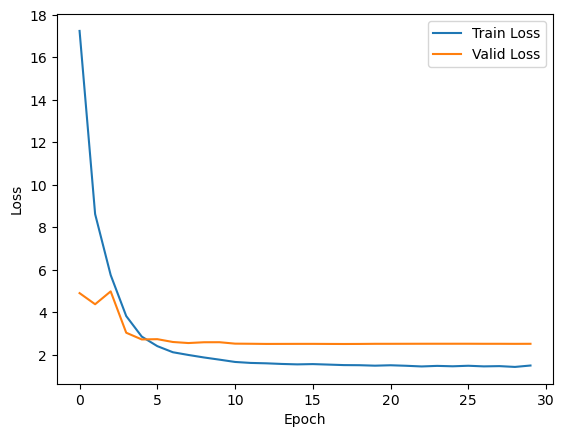

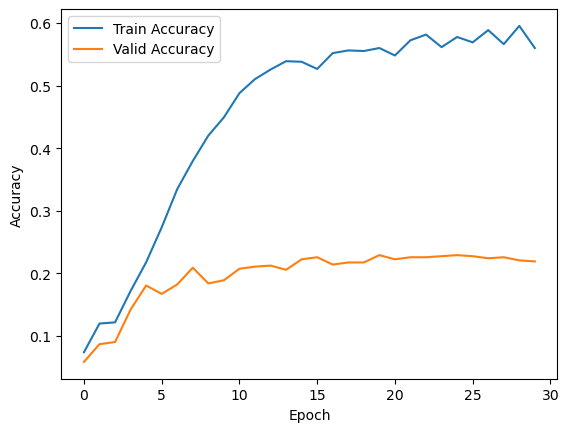

Most Misclassified Class: Boxer
Accuracy: 0.2026578073089701
False Positive: [ 8 14 28 24 16 22 17 15 10 15 18 13  8 13 19]
False Negative: [14 15 16 18 27 21 15 18 16 10 15 20  5 19 11]
True Positive: [4 1 6 1 2 3 1 2 6 6 4 5 9 5 6]
True Negative: [275 271 251 258 256 255 268 266 269 270 264 263 279 264 265]


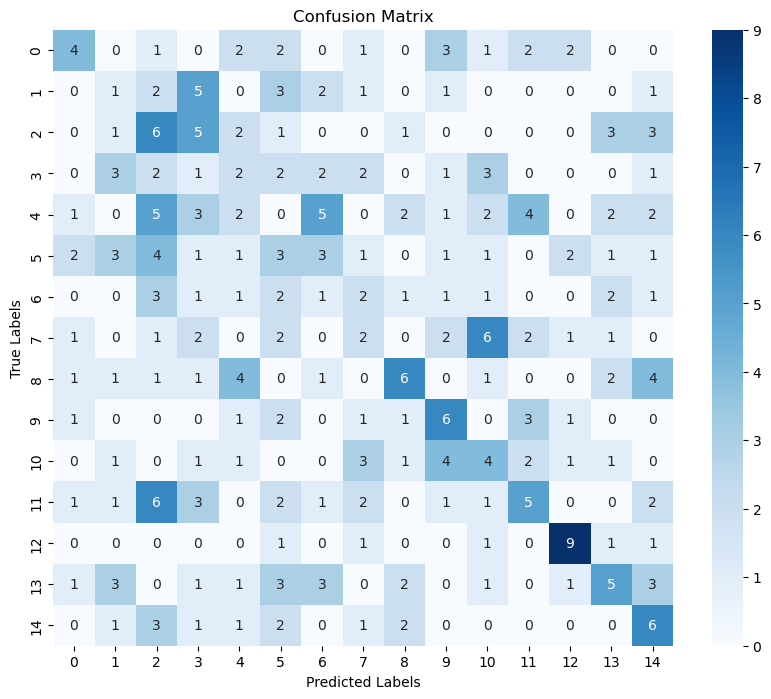

In [65]:
Loss = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters())
patience=4
epochs = 30
history= fit_to_model(train_dataset_loader, valid_dataset_loader,test_dataset_loader, epochs,optimizer, Loss, model, patience)

This time, I tried my dataset with a lower learning rate. However, I obtained an underfit graph. 
As can be seen, the loss values are moving in parallel. And there is no learning taking place in the model at all.

In [30]:



Loss = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(),lr=0.0001)
patience=4
epochs = 100
history = fit_to_model(train_dataset_loader,valid_dataset_loader, epochs, optimizer, Loss, model, patience)



Epoch [1/100] => Train Loss: 1.788, Val Loss: 2.790, Train Acc: 0.406, Val Acc: 0.180
Epoch [2/100] => Train Loss: 1.758, Val Loss: 2.582, Train Acc: 0.426, Val Acc: 0.246
Epoch [3/100] => Train Loss: 1.676, Val Loss: 2.594, Train Acc: 0.448, Val Acc: 0.246
Epoch [4/100] => Train Loss: 1.640, Val Loss: 2.564, Train Acc: 0.454, Val Acc: 0.234
Epoch [5/100] => Train Loss: 1.632, Val Loss: 2.504, Train Acc: 0.458, Val Acc: 0.246
Epoch [6/100] => Train Loss: 1.598, Val Loss: 2.567, Train Acc: 0.471, Val Acc: 0.246
Epoch [7/100] => Train Loss: 1.612, Val Loss: 2.571, Train Acc: 0.464, Val Acc: 0.246
Epoch [8/100] => Train Loss: 1.563, Val Loss: 2.568, Train Acc: 0.479, Val Acc: 0.219
Epoch [9/100] => Train Loss: 1.523, Val Loss: 2.548, Train Acc: 0.491, Val Acc: 0.254
Early stopping triggered


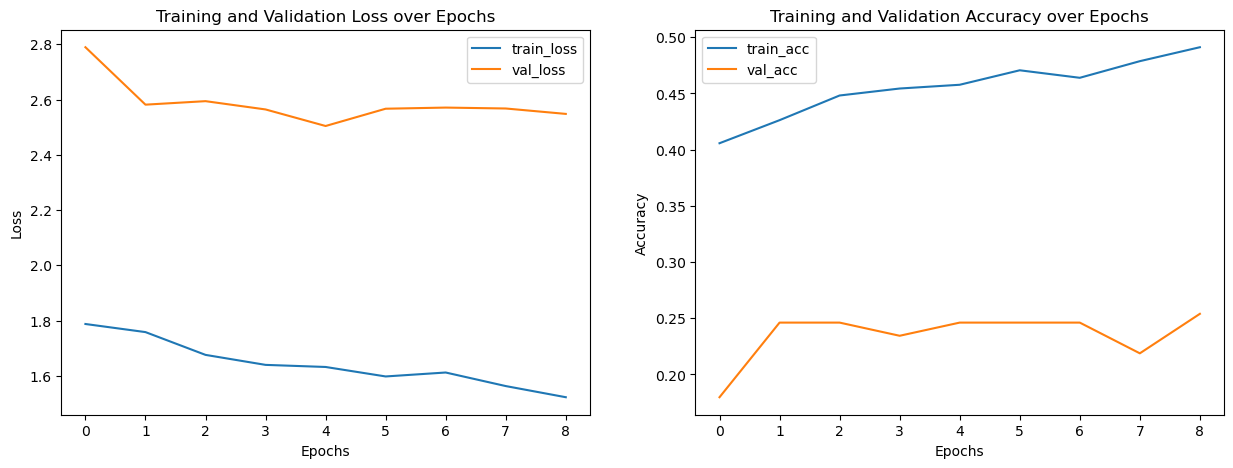

In [31]:
plot_history(history)

To prevent underfitting, I considered expanding the dataset. I conducted the same experiment with an augmented dataset.
However, I did not observe any improvement in this case either."


In [41]:


Loss = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters())
patience=4
epochs = 100
history = fit_to_model(aug_train_dataset_loader, aug_valid_dataset_loader, epochs, optimizer, Loss, model, patience)


Epoch [1/100] => Train Loss: 12.468, Val Loss: 7.915, Train Acc: 0.079, Val Acc: 0.105
Epoch [2/100] => Train Loss: 5.644, Val Loss: 3.401, Train Acc: 0.121, Val Acc: 0.219
Epoch [3/100] => Train Loss: 3.385, Val Loss: 3.053, Train Acc: 0.152, Val Acc: 0.133
Epoch [4/100] => Train Loss: 2.905, Val Loss: 2.848, Train Acc: 0.180, Val Acc: 0.168
Epoch [5/100] => Train Loss: 2.633, Val Loss: 2.841, Train Acc: 0.195, Val Acc: 0.168
Epoch [6/100] => Train Loss: 2.557, Val Loss: 2.635, Train Acc: 0.209, Val Acc: 0.176
Epoch [7/100] => Train Loss: 2.476, Val Loss: 2.718, Train Acc: 0.232, Val Acc: 0.188
Epoch [8/100] => Train Loss: 2.364, Val Loss: 2.717, Train Acc: 0.252, Val Acc: 0.219
Epoch [9/100] => Train Loss: 2.444, Val Loss: 2.526, Train Acc: 0.239, Val Acc: 0.234
Epoch [10/100] => Train Loss: 2.365, Val Loss: 2.665, Train Acc: 0.263, Val Acc: 0.133
Epoch [11/100] => Train Loss: 2.294, Val Loss: 2.731, Train Acc: 0.281, Val Acc: 0.191
Epoch [12/100] => Train Loss: 2.255, Val Loss: 2.75

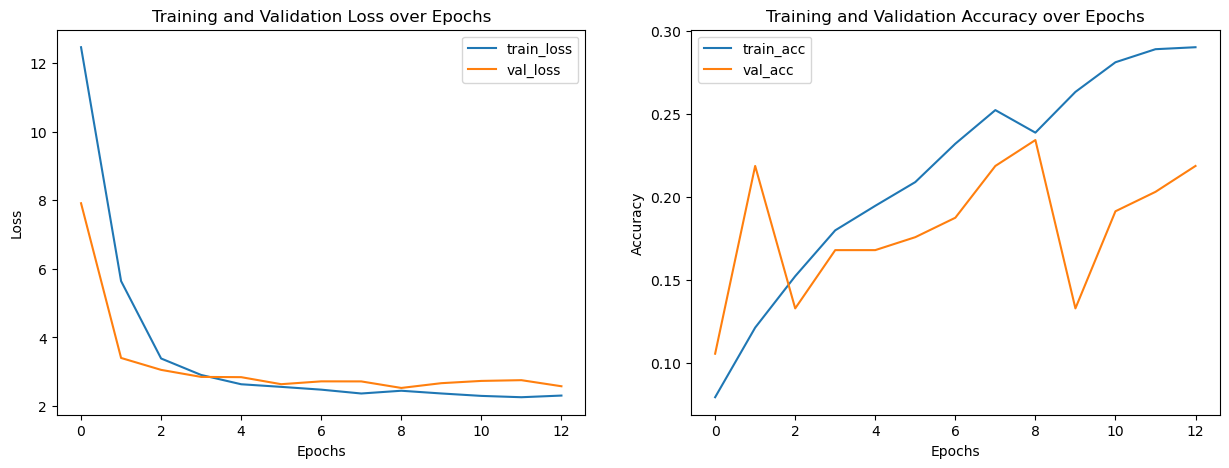

In [43]:
plot_history(history)

In this experiment, I tried a different learning rate on augmented dataset. While the training accuracy showed
a slight increase,I observed that the model, in general, did not demonstrate learning.

In [26]:


Loss = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.0001)
patience=4
epochs = 100
history = fit_to_model(aug_train_dataset_loader, aug_valid_dataset_loader, epochs, optimizer, Loss, model, patience)


Epoch [1/100] => Train Loss: 2.925, Val Loss: 2.715, Train Acc: 0.104, Val Acc: 0.121
Epoch [2/100] => Train Loss: 2.579, Val Loss: 2.545, Train Acc: 0.175, Val Acc: 0.176
Epoch [3/100] => Train Loss: 2.487, Val Loss: 2.619, Train Acc: 0.202, Val Acc: 0.230
Epoch [4/100] => Train Loss: 2.395, Val Loss: 2.525, Train Acc: 0.240, Val Acc: 0.199
Epoch [5/100] => Train Loss: 2.335, Val Loss: 2.463, Train Acc: 0.251, Val Acc: 0.238
Epoch [6/100] => Train Loss: 2.247, Val Loss: 2.388, Train Acc: 0.284, Val Acc: 0.277
Epoch [7/100] => Train Loss: 2.188, Val Loss: 2.387, Train Acc: 0.309, Val Acc: 0.207
Epoch [8/100] => Train Loss: 2.118, Val Loss: 2.332, Train Acc: 0.335, Val Acc: 0.293
Epoch [9/100] => Train Loss: 2.072, Val Loss: 2.425, Train Acc: 0.342, Val Acc: 0.266
Epoch [10/100] => Train Loss: 2.067, Val Loss: 2.467, Train Acc: 0.339, Val Acc: 0.211
Epoch [11/100] => Train Loss: 1.979, Val Loss: 2.351, Train Acc: 0.371, Val Acc: 0.281
Epoch [12/100] => Train Loss: 1.908, Val Loss: 2.392

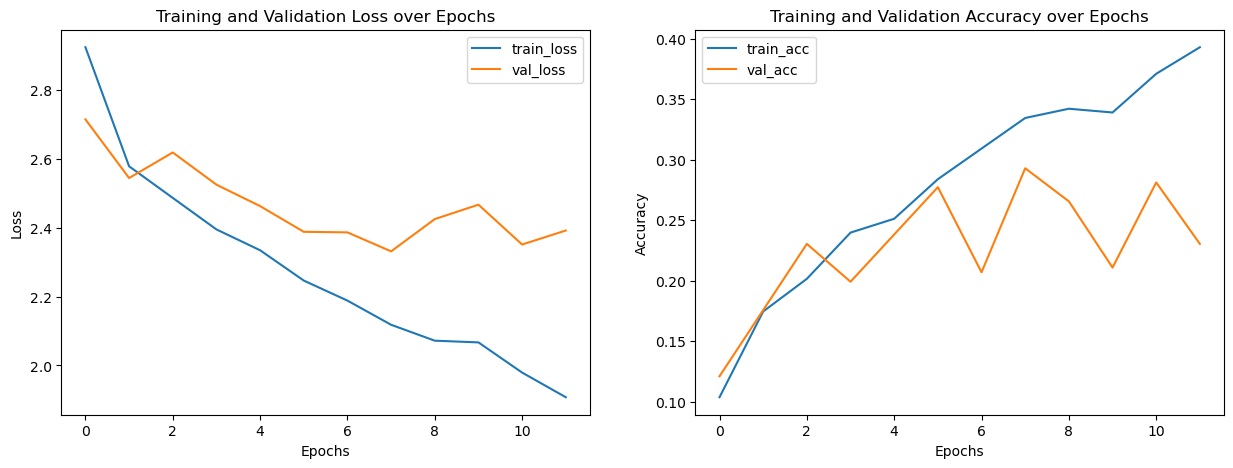

In [27]:
plot_history(history)

RESNET-18 Implementation


Explore training different number of layers such as; train all FC layers or some of it, or start training the
last conv layer and the rest of FC layers and so on. Tune your parameters accordingly and give accuracy on
validation set. Compare your results.

The reason for reloading the data in this part was that I was processing images as 100 x 100 because my base cnn model had 400 x 400 image sizes and memory was insufficient. But when I implemented resnet, I processed the size of the images as 400 x 400. I did not encounter any memory shortage problem during the training.

In [81]:
import torch
import pandas as pd
from torchvision.datasets.folder import default_loader
from torch.utils.data import Dataset
from torchvision.transforms import ToTensor, Resize, Compose

class CustomDataset(Dataset):
    def __init__(self, csv_file, root_dir):
        self.data = pd.read_csv(csv_file)
        self.root_dir = root_dir
        self.classes = sorted(self.data['class'].unique())  
        self.class_to_index = {c: i for i, c in enumerate(self.classes)}  
        
        self.transform = Compose([
            torchvision.transforms.Resize((400,400)),
#             torchvision.transforms.RandomHorizontalFlip(),  # Flip augmentation
            torchvision.transforms.ToTensor(),
            torchvision.transforms.Normalize(mean=[0.5,0.5,0.5], std=[0.5,0.5,0.5]), 
        ])
    def __len__(self):
        return len(self.data)

    def __getitem__(self, index):
        img_name = os.path.join(self.root_dir, str(self.data.iloc[index, 0]) + ".jpg")
        image = default_loader(img_name)
        image = self.transform(image) 

        label = self.data.iloc[index, 4]


        return image,label


csv_file = "new_dog_dataset.csv"  
root_dir = "images"
dataset = CustomDataset(csv_file, root_dir)



In [82]:
BATCH_SIZE=256
#data
train_count = int(0.7 * len(dataset)) 
valid_count = int(0.2 * len(dataset))
test_count = len(dataset) - train_count - valid_count
train_dataset, valid_dataset, test_dataset = torch.utils.data.random_split(dataset, (train_count, valid_count, test_count))
train_dataset_loader = torch.utils.data.DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)  
valid_dataset_loader = torch.utils.data.DataLoader(valid_dataset, batch_size=BATCH_SIZE, shuffle=True) 
test_dataset_loader  = torch.utils.data.DataLoader(test_dataset , batch_size=BATCH_SIZE, shuffle=False)
dataloaders = {'train': train_dataset_loader, 'val': valid_dataset_loader, 'test': test_dataset_loader}

In [107]:

class_names = train_dataset.dataset.classes
print(class_names)

['American Bulldog', 'American Pit Bull Terrier', 'Basset Hound', 'Beagle', 'Boxer', 'Chihuahua', 'English Cocker Spaniel', 'English Setter', 'German Shorthaired', 'Great Pyrenees', 'Havanese', 'Japanese Chin', 'Keeshond', 'Leonberger', 'Miniature Pinscher']


I wrote a resnet_train function to do all the experiments easily. 

The parameter, the optimizer, accepts Adam or SGD. The model architecture also changes according to the dropout rate. Epoch count, train, test and validation datasets are other parameters.

In [87]:
import torch
import torch.nn as nn
import torchvision.models as models

def resnet_train(optimizer,dropout_rate, num_epochs,train_dataset_loader,valid_dataset_loader,test_dataset_loader):
    num_classes = 15

    model = models.resnet18(pretrained=True)

    for param in model.parameters():
        param.requires_grad = False

    num_ftrs = model.fc.in_features
    
    if dropout_rate!=0:
        print("dropout applied")
        model.fc = nn.Sequential(
        nn.Linear(num_ftrs, 512),
        nn.ReLU(),
        nn.Dropout(dropout_rate),
        nn.Linear(512, num_classes)
    )
    else:
        print("dropout is not applied")
        model.fc = nn.Linear(num_ftrs, num_classes)

    criterion = nn.CrossEntropyLoss()
    if optimizer== "SGD":
        optimizer = torch.optim.SGD(model.fc.parameters(), lr=0.001)
    else:
        optimizer = torch.optim.Adam(model.fc.parameters(), lr=0.001)

    train_loss_values = []
    train_acc_values = []
    valid_loss_values = []
    valid_acc_values = []

    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0
        correct_train = 0
        total_train = 0

        for images, labels in train_dataset_loader:
            images = images.to(device)
            labels = labels.to(device)

            optimizer.zero_grad()

            outputs = model(images)
            loss = criterion(outputs, labels)

            loss.backward()
            optimizer.step()

            running_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total_train += labels.size(0)
            correct_train += (predicted == labels).sum().item()

        epoch_loss = running_loss / len(train_dataset)
        epoch_train_acc = correct_train / total_train

        train_loss_values.append(epoch_loss)
        train_acc_values.append(epoch_train_acc)

        model.eval()
        valid_loss = 0.0
        correct_valid = 0
        total_valid = 0

        with torch.no_grad():
            for images, labels in valid_dataset_loader:
                images = images.to(device)
                labels = labels.to(device)

                outputs = model(images)
                loss = criterion(outputs, labels)
                valid_loss += loss.item()

                _, predicted = torch.max(outputs.data, 1)
                total_valid += labels.size(0)
                correct_valid += (predicted == labels).sum().item()

        epoch_valid_loss = valid_loss / len(valid_dataset)
        epoch_valid_acc = correct_valid / total_valid

        valid_loss_values.append(epoch_valid_loss)
        valid_acc_values.append(epoch_valid_acc)

        print(f"Epoch {epoch+1}/{num_epochs}, Loss: {epoch_loss}, Train Acc: {epoch_train_acc}, Valid Loss: {epoch_valid_loss}, Valid Acc: {epoch_valid_acc}")
    
    plot_loss_acc(train_loss_values,valid_loss_values,train_acc_values,valid_acc_values)
    create_confmatrix(model,test_dataset_loader)
    return model

In this experiment, since dropout rate = 0, only the Linear layer is added to the resnet model 
without entering the Dropout loop in the resnet train function and training is performed in this way.

As can be seen in the graph, the ResNet model has shown a remarkable example of a good fit. As also seen in the confusion matrix, it has misclassified only a few examples in the tested classes. In the first experiment, I used Adam as the optimizer, and I didn't apply dropout. If you look at my resnet_train() function, you can see the difference in my model architecture with and without dropout applied.

dropout is not applied
Epoch 1/30, Loss: 0.010992196522350813, Train Acc: 0.15465393794749405, Valid Loss: 0.011344791256065752, Valid Acc: 0.3695652173913043
Epoch 2/30, Loss: 0.00869438744956952, Train Acc: 0.513126491646778, Valid Loss: 0.00885686946154438, Valid Acc: 0.7207357859531772
Epoch 3/30, Loss: 0.006903601716981583, Train Acc: 0.7050119331742244, Valid Loss: 0.007162690960045243, Valid Acc: 0.8160535117056856
Epoch 4/30, Loss: 0.005632708977401114, Train Acc: 0.8186157517899761, Valid Loss: 0.00597248029549385, Valid Acc: 0.862876254180602
Epoch 5/30, Loss: 0.004683744366811966, Train Acc: 0.8610978520286396, Valid Loss: 0.0049419833664910056, Valid Acc: 0.8913043478260869
Epoch 6/30, Loss: 0.003978901945036749, Train Acc: 0.875417661097852, Valid Loss: 0.004312562503942279, Valid Acc: 0.8862876254180602
Epoch 7/30, Loss: 0.003469324737858374, Train Acc: 0.8954653937947494, Valid Loss: 0.0038549431590332237, Valid Acc: 0.9147157190635451
Epoch 8/30, Loss: 0.003067859971722

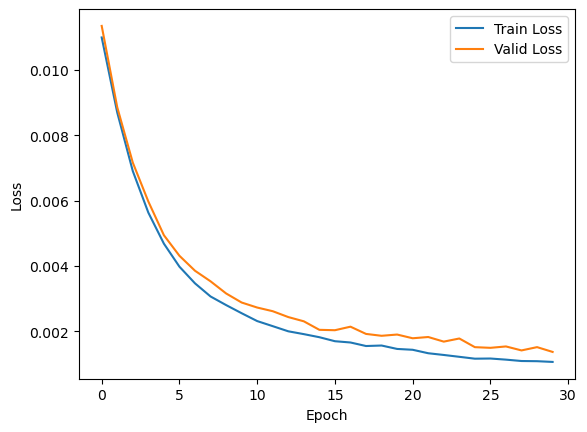

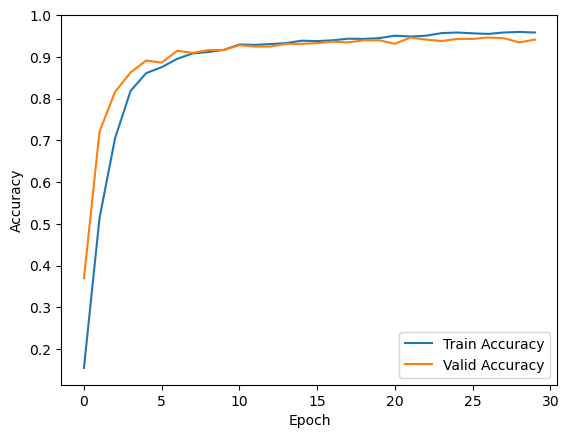

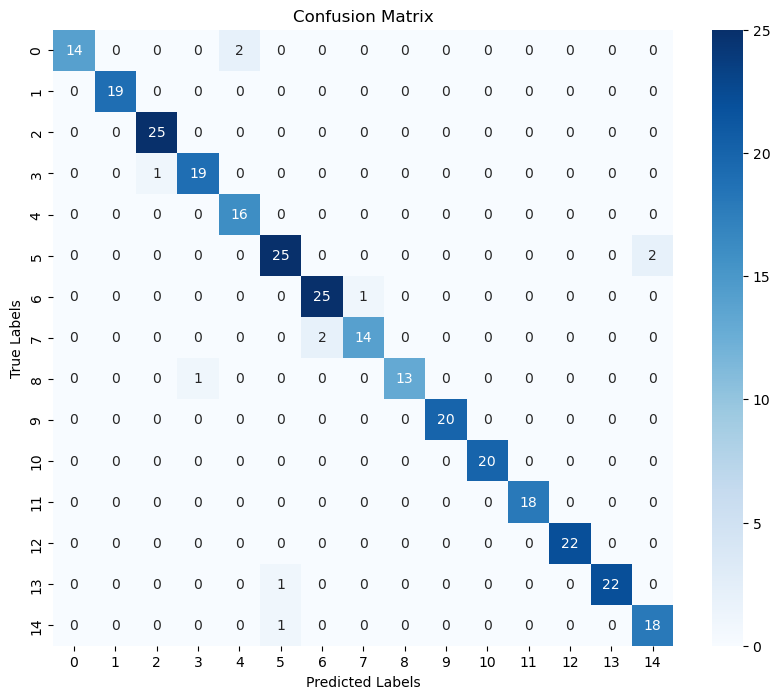

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [88]:
optimizer= "Adam"
num_epochs=30
dropout_rate=0
model=resnet_train(optimizer,dropout_rate, num_epochs,train_dataset_loader,valid_dataset_loader,test_dataset_loader)

In [98]:
torch.save(model.state_dict(), "resnetfc.pt")


As seen in the confusion matrix, the model achieves good results even on test data it has never seen before. The most commonly misclassified class has been identified as "Basset Hound". In the confusion matrix, the values on the left are the true class labels, and the ones at the bottom are the labels predicted by the model. 

I have identified the class that is most often misclassified by associating class labels, which I kept as indices, with class names using a function, and examining the values in the confusion matrix. However, this can also be calculated by summing up the values that do not match with the true class from left to right. 

Finally, the test accuracy of the model is calculated 71%.

Most Misclassified Class: Basset Hound
Accuracy: 0.717607973421927
False Positive: [ 4  6  0 28  2 11  4 10  0  5  6  1  3  1  4]
False Negative: [ 8 13 17  1  7  0  3  8 14  1  0  3  2  4  4]
True Positive: [ 8  6  8 19  9 27 23  8  0 19 20 15 20 19 15]
True Negative: [281 276 276 253 283 263 271 275 287 276 275 282 276 277 278]


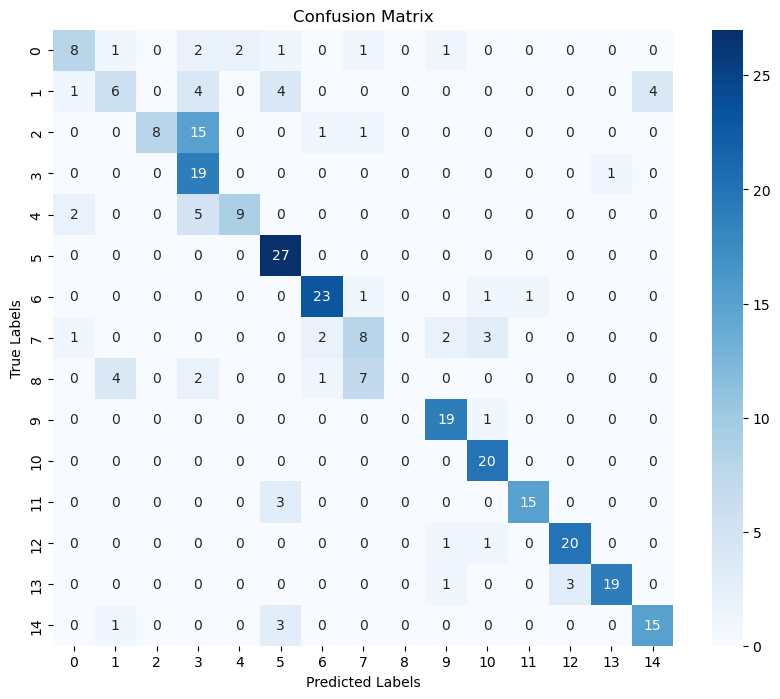

In [128]:
create_confmatrix(newmodel,test_dataset_loader)



Below, I made some predictions on sample images from the test dataset. 
As can be seen, the model correctly classified all the given images.


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


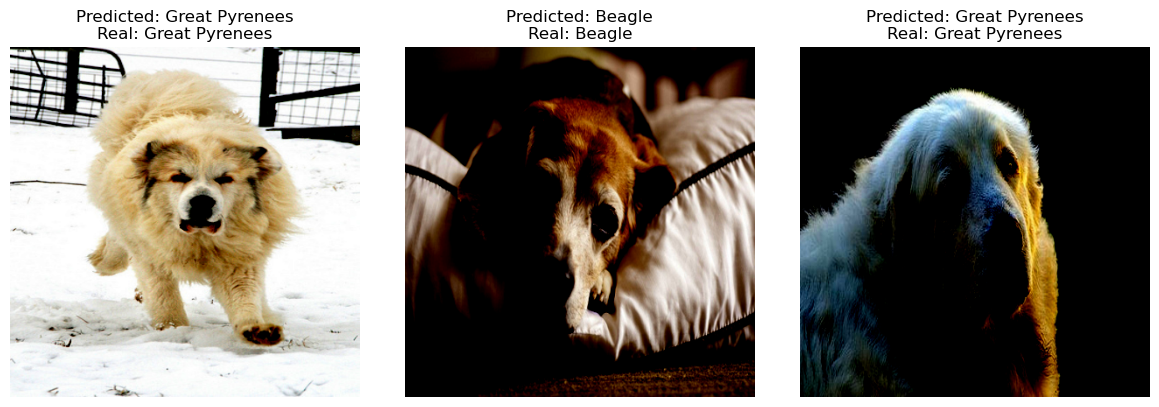

In [115]:



model = model.cpu()
with torch.no_grad():
    fig, axs = plt.subplots(1, 3, figsize=(12, 4))  
    
    for i, (imgs, labels) in enumerate(test_dataset_loader):
        if i >= 3: 
            break
        
        imgs = imgs.cpu()
        labels = labels.cpu()
        output_model = model(imgs)
        _, predicted = torch.max(output_model, 1)
        
        for j in range(len(imgs)):
            img = imgs[j].permute(1, 2, 0)
            label = labels[j]
            pred = predicted[j]
            
            axs[i].imshow(img)
            axs[i].set_title(f"Predicted: {dataset.classes[pred]}\nReal: {dataset.classes[label]}")
            axs[i].axis('off')
            i += 1
            
            if i >= 3:
                break

    plt.tight_layout()
    plt.show()


Below, since the dropout_rate is set to 0.25, in the resnet_train function, the dropout query is executed, the dropout is applied within the Sequential layer,it is linearized after the activation function, and the training is conducted in this way.
Dropout was applied to the model at a rate of 0.25 to see its effect. However, since the model was already learning well, it didn't contribute much; although the training accuracy slightly increased, no improvement was observed in validation accuracy. Perhaps if tried with higher rates like 0.5, an improvement in validation accuracy could be seen.

C:\Users\Melike.Colak\AppData\Local\anaconda3\envs\waf\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and will be removed in 0.15, please use 'weights' instead.
  warnings.warn(
C:\Users\Melike.Colak\AppData\Local\anaconda3\envs\waf\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


dropout applied
Epoch 1/30, Loss: 0.009595250855766789, Train Acc: 0.38138424821002387, Valid Loss: 0.008248938365923521, Valid Acc: 0.7391304347826086
Epoch 2/30, Loss: 0.0052908390120276405, Train Acc: 0.7761336515513126, Valid Loss: 0.004447139326146614, Valid Acc: 0.862876254180602
Epoch 3/30, Loss: 0.003081356881626466, Train Acc: 0.8372315035799522, Valid Loss: 0.0026045408735307163, Valid Acc: 0.9080267558528428
Epoch 4/30, Loss: 0.002178978578572057, Train Acc: 0.8778042959427208, Valid Loss: 0.001974164293362544, Valid Acc: 0.919732441471572
Epoch 5/30, Loss: 0.0016696140276788243, Train Acc: 0.9054892601431981, Valid Loss: 0.0017572458472140259, Valid Acc: 0.9147157190635451
Epoch 6/30, Loss: 0.0013996535667656145, Train Acc: 0.9136038186157518, Valid Loss: 0.0014402474647381633, Valid Acc: 0.931438127090301
Epoch 7/30, Loss: 0.0012211925872470427, Train Acc: 0.9298329355608592, Valid Loss: 0.0013615740681173012, Valid Acc: 0.9331103678929766
Epoch 8/30, Loss: 0.0010394512326

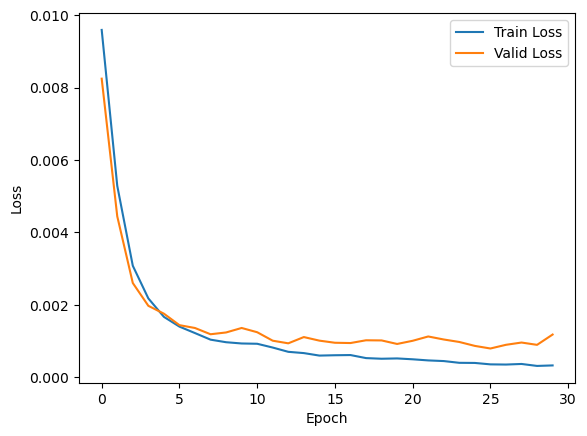

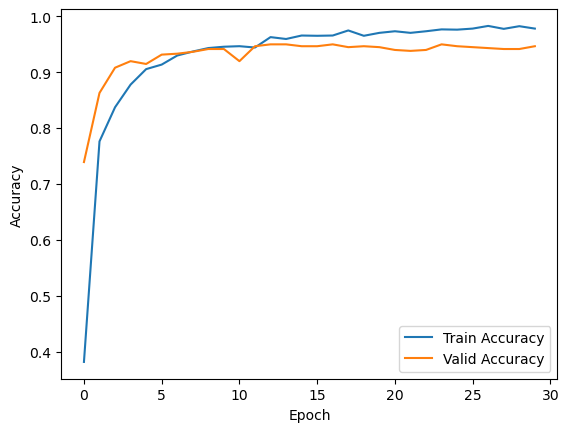

Most Misclassified Class: Chihuahua
Accuracy: 0.9435215946843853
False Positive: [0 4 0 0 3 1 1 3 0 1 0 0 1 0 3]
False Negative: [4 0 0 1 0 5 3 1 1 0 0 0 0 1 1]
True Positive: [12 19 25 19 16 22 23 15 13 20 20 18 22 22 18]
True Negative: [285 278 276 281 282 273 274 282 287 280 281 283 278 278 279]


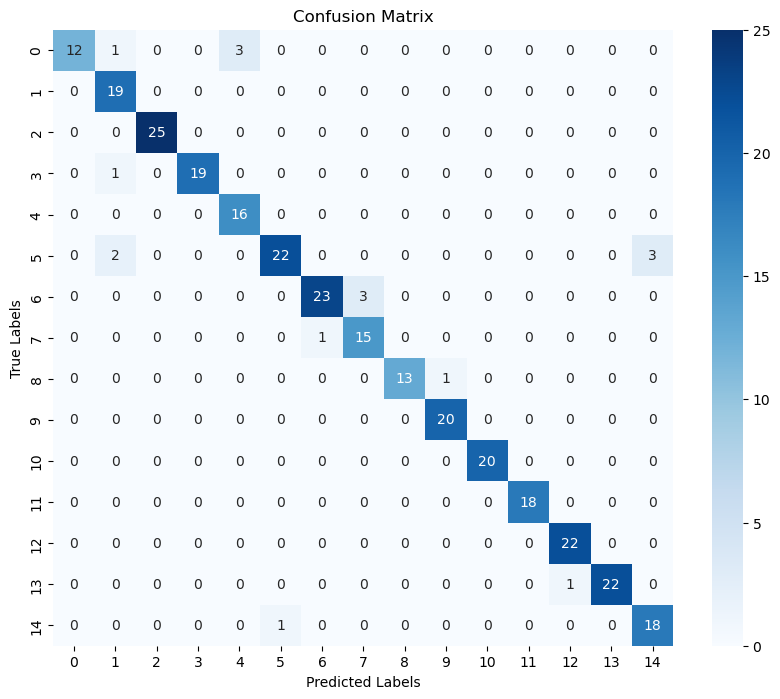

In [117]:
optimizer= "Adam"
num_epochs=30
dropout_rate=0.25
model=resnet_train(optimizer,dropout_rate, num_epochs,train_dataset_loader,valid_dataset_loader,test_dataset_loader)

In [130]:
torch.save(model.state_dict(), "resnetdropout.pt")


As seen in the confusion matrix, the model achieves good results even on test data it has never seen before. The most commonly misclassified class has been identified as "American Bulldog". In the confusion matrix, the values on the left are the true class labels, and the ones at the bottom are the labels predicted by the model. In this experiment, test accuracy calculated as 94%

Most Misclassified Class: American Bulldog
Accuracy: 0.9464882943143813
False Positive: [ 1 12  4  1  4  0  2  3  2  1  0  0  0  0  2]
False Negative: [9 1 1 6 4 2 1 2 3 1 0 0 0 0 2]
True Positive: [31 44 36 36 31 35 41 36 35 46 40 36 48 34 37]
True Negative: [557 541 557 555 559 561 554 557 558 550 558 562 550 564 557]


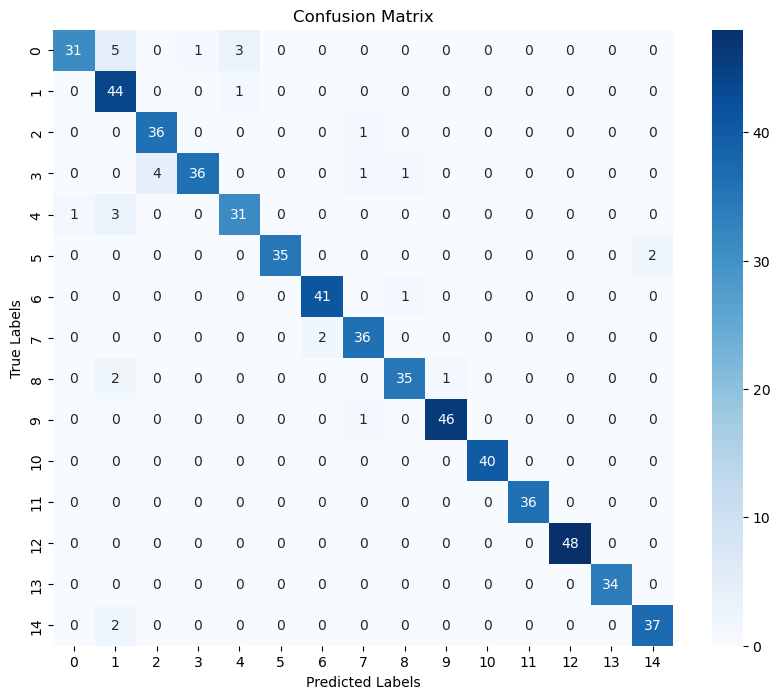

In [129]:


create_confmatrix(model,test_dataset_loader)

COMPARING TASK 1 and TASK 2



Unfortunately, the model I trained from scratch could not demonstrate any learning.
In order for the model to learn better, I applied data augmentation techniques. I also added a Dropout layer as a 
regularization method and implemented early stopping. I added L1 and L2 regularization as well, but there was no change
in the experiments. In addition, I used the Learning Rate Scheduler method that adjusts the learning rate during training.
I changed my model and tried different architectures, but still, there was no improvement. Due to memory insufficiency, 
I was sending the data to training after resizing them to 100 x 100 pixels, rather than in their original sizes.
Therefore, it might be difficult for the model to learn the features according to dog breeds because the size of the
images dropped significantly. Also, I resized all the images to square shapes. This might have caused a substantial
amount of distortion for images where the height and width values are quite different. 

After all, there's a 'garbage in, garbage out' rule in deep learning :)


In Task 2, I used my own features integrated into the last layer of ResNet. To observe the effect of Dropout, I conducted two different experiments. Both models showed high performance on both the validation and test datasets. While the test accuracy of one model was 71%, the model with Dropout applied achieved an accuracy rate of 94%. As evident from all the accuracy and loss graphs, both models are in a good fit state.

After all these experiments, considering the class weights and aiming to improve the learning of the model, I have decided to integrate an attention mechanism into the ResNet architecture in Task 3.


ATTENTION MODEL 

The attention mechanism in deep learning is a technique that allows the model to focus on specific parts of the input data when making predictions or performing tasks. It helps the model to weigh the importance of different elements or features of the input and allocate its attention accordingly.Overall, the attention mechanism enhances the model's ability to capture important patterns and dependencies in the data, leading to improved performance in various tasks.

By integrating the attention mechanism into layers 3 and 4 of ResNet, I have enhanced the model's ability to focus on relevant features and capture long-range dependencies. This integration can help improve the model's discrimination capabilities and adaptability to varying input conditions. Integrating attention mechanisms into ResNet's layer 3 and layer 4 brings several benefits. It allows the model to selectively focus on relevant features, capturing long-range dependencies and improving the model's ability to discriminate between different classes. By guiding the model's attention to important features, attention mechanisms enhance its understanding of global contextual information and adaptability to varying input conditions. This integration aims to improve the model's performance on complex tasks by leveraging the power of attention to enhance feature representation and decision-making in ResNet's higher-level layers.


When looking at the results of the model trained with the layer4_attention_resnet() function, it can be observed that the performance is at least as good as Task 2. The application of the attention mechanism to layer 4 achieves the highest result, with an accuracy of 95%, among all the experiments conducted in this assignment.

Examining the results of the layer3_attention_resnet(), we see that the accuracy and loss values are again very high. The test accuracy is measured at 94%.

In both training experiments, it is observed that the most misclassified class is Chihuahua.

A good fit is defined by a stable point with a minimal gap between two final loss values and a training and validation loss that steadily decrease. The model's loss will almost always be lower in the training dataset compared to the validation dataset. This implies that we should expect some gap, called "generalization gap," between the learning curves of training and validation loss. Based on this information, we can say that both experiments are in a good fit form.



In [131]:
import torch
import torch.nn as nn
import torchvision.models as models

def layer4_attention_resnet(optimizer,dropout_rate, num_epochs,train_dataset_loader,valid_dataset_loader,test_dataset_loader):
    num_classes = 15
    model = models.resnet18(pretrained=True)

    for param in model.parameters():
        param.requires_grad = False

    num_ftrs = model.fc.in_features

    model.layer4.add_module('SoftAttention', SoftAttention(num_ftrs))

    if dropout_rate != 0:
        print("dropout applied")
        model.fc = nn.Sequential(
            nn.Linear(num_ftrs, 512),
            nn.ReLU(),
            nn.Dropout(dropout_rate),
            nn.Linear(512, num_classes)
        )
    else:
        print("dropout is not applied")
        model.fc = nn.Linear(num_ftrs, num_classes)

    criterion = nn.CrossEntropyLoss()
    if optimizer == "SGD":
        optimizer = torch.optim.SGD(model.fc.parameters(), lr=0.001)
    else:
        optimizer = torch.optim.Adam(model.fc.parameters(), lr=0.001)

    train_loss_values = []
    train_acc_values = []
    valid_loss_values = []
    valid_acc_values = []

    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0
        correct_train = 0
        total_train = 0

        for images, labels in train_dataset_loader:
            images = images.to(device)
            labels = labels.to(device)

            optimizer.zero_grad()

            outputs = model(images)
            loss = criterion(outputs, labels)

            loss.backward()
            optimizer.step()

            running_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total_train += labels.size(0)
            correct_train += (predicted == labels).sum().item()

        epoch_loss = running_loss / len(train_dataset)
        epoch_train_acc = correct_train / total_train

        train_loss_values.append(epoch_loss)
        train_acc_values.append(epoch_train_acc)

        model.eval()
        valid_loss = 0.0
        correct_valid = 0
        total_valid = 0

        with torch.no_grad():
            for images, labels in valid_dataset_loader:
                images = images.to(device)
                labels = labels.to(device)

                outputs = model(images)
                loss = criterion(outputs, labels)
                valid_loss += loss.item()

                _, predicted = torch.max(outputs.data, 1)
                total_valid += labels.size(0)
                correct_valid += (predicted == labels).sum().item()

        epoch_valid_loss = valid_loss / len(valid_dataset)
        epoch_valid_acc = correct_valid / total_valid

        valid_loss_values.append(epoch_valid_loss)
        valid_acc_values.append(epoch_valid_acc)

        print(f"Epoch {epoch+1}/{num_epochs}, Loss: {epoch_loss}, Train Acc: {epoch_train_acc}, Valid Loss: {epoch_valid_loss}, Valid Acc: {epoch_valid_acc}")

    plot_loss_acc(train_loss_values,valid_loss_values,train_acc_values,valid_acc_values)
    create_confmatrix(model,test_dataset_loader)
    return model

C:\Users\Melike.Colak\AppData\Local\anaconda3\envs\waf\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and will be removed in 0.15, please use 'weights' instead.
  warnings.warn(
C:\Users\Melike.Colak\AppData\Local\anaconda3\envs\waf\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


dropout applied
Epoch 1/30, Loss: 0.00951724564545479, Train Acc: 0.3847255369928401, Valid Loss: 0.008257951624816079, Valid Acc: 0.7341137123745819
Epoch 2/30, Loss: 0.00553688138083228, Train Acc: 0.7279236276849642, Valid Loss: 0.004690030047726073, Valid Acc: 0.8193979933110368
Epoch 3/30, Loss: 0.003353591807417767, Train Acc: 0.8190930787589499, Valid Loss: 0.0028671471769594428, Valid Acc: 0.9180602006688964
Epoch 4/30, Loss: 0.0022847866812867597, Train Acc: 0.8768496420047732, Valid Loss: 0.002137209958456033, Valid Acc: 0.9180602006688964
Epoch 5/30, Loss: 0.0018243719114608582, Train Acc: 0.8997613365155132, Valid Loss: 0.0016974706115531284, Valid Acc: 0.9247491638795987
Epoch 6/30, Loss: 0.001446074745251057, Train Acc: 0.9140811455847255, Valid Loss: 0.0016079969629396165, Valid Acc: 0.9347826086956522
Epoch 7/30, Loss: 0.0012451791464571167, Train Acc: 0.9279236276849642, Valid Loss: 0.0014394316884586244, Valid Acc: 0.939799331103679
Epoch 8/30, Loss: 0.001088577309770

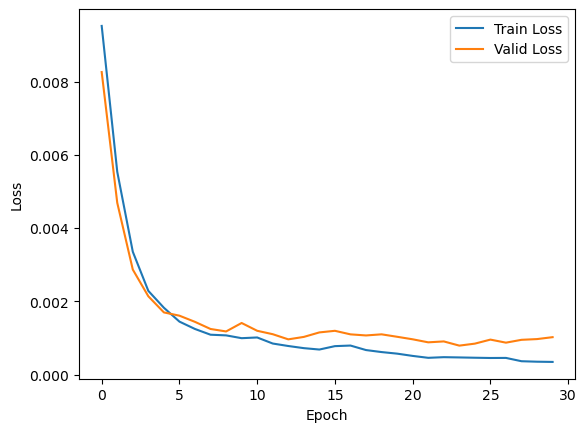

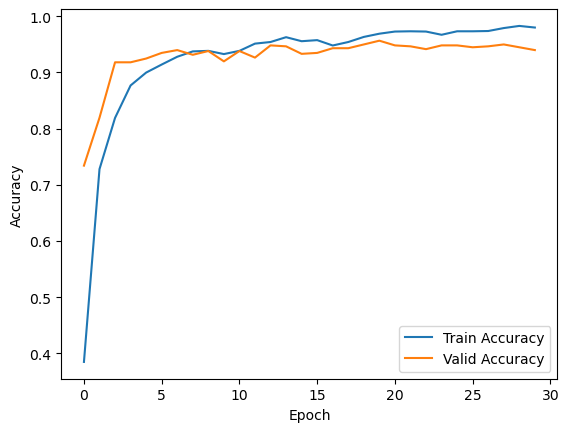

Most Misclassified Class: Chihuahua
Accuracy: 0.9534883720930233
False Positive: [1 2 1 1 2 0 1 1 0 0 0 0 1 0 4]
False Negative: [2 0 0 1 1 6 1 1 1 0 0 0 0 1 0]
True Positive: [14 19 25 19 15 21 25 15 13 20 20 18 22 22 19]
True Negative: [284 280 275 280 283 274 274 284 287 281 281 283 278 278 278]


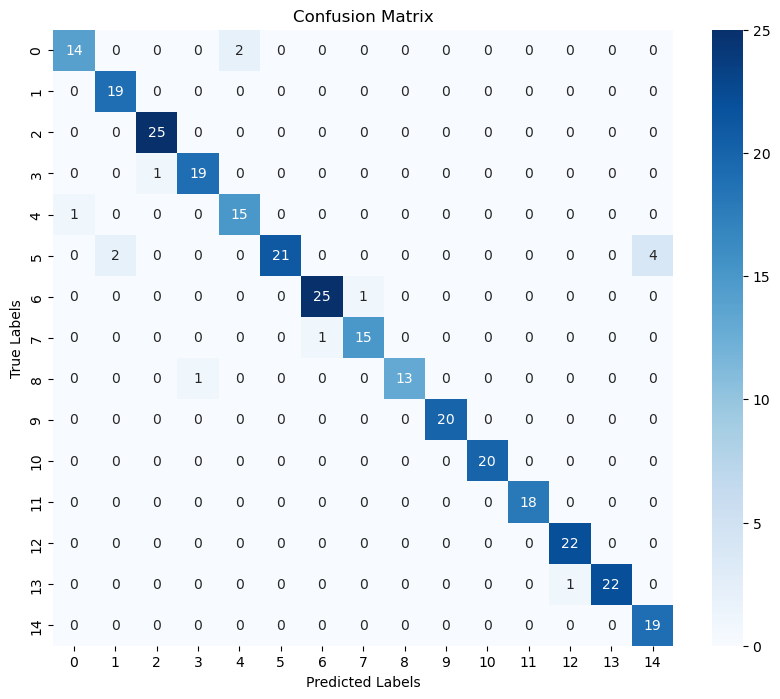

In [132]:
optimizer= "Adam"
num_epochs=30
dropout_rate=0.25
attention_model=layer4_attention_resnet(optimizer,dropout_rate, num_epochs,train_dataset_loader,valid_dataset_loader,test_dataset_loader)

In [133]:
torch.save(model.state_dict(), "attentionresnet.pt")


Most Misclassified Class: Chihuahua
Accuracy: 0.9534883720930233
False Positive: [1 2 1 1 2 0 1 1 0 0 0 0 1 0 4]
False Negative: [2 0 0 1 1 6 1 1 1 0 0 0 0 1 0]
True Positive: [14 19 25 19 15 21 25 15 13 20 20 18 22 22 19]
True Negative: [284 280 275 280 283 274 274 284 287 281 281 283 278 278 278]


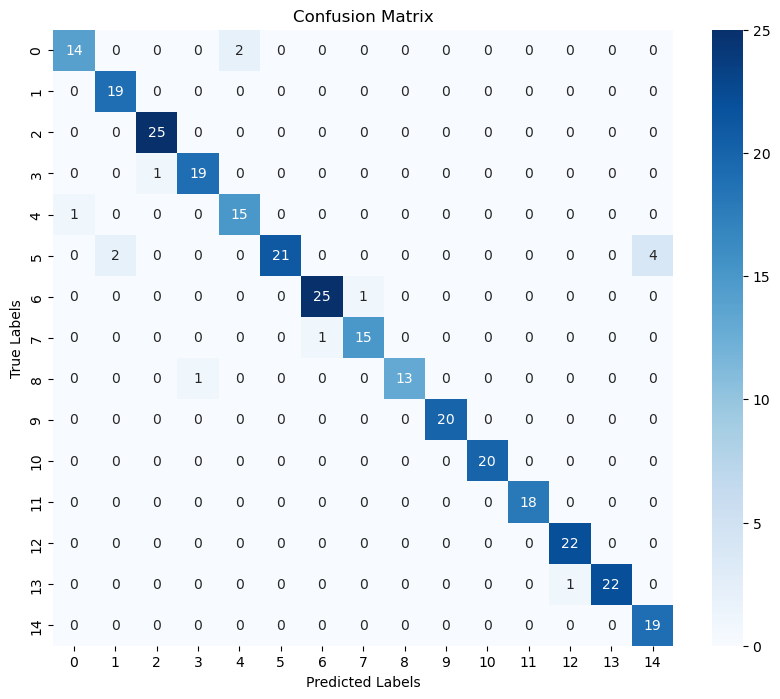

In [135]:
create_confmatrix(attention_model,test_dataset_loader)

In [137]:
import torch
import torch.nn as nn
import torchvision.models as models

def layer3_attention_resnet(optimizer,dropout_rate, num_epochs,train_dataset_loader,valid_dataset_loader,test_dataset_loader):
    num_classes = 15
    model = models.resnet18(pretrained=True)

    for param in model.parameters():
        param.requires_grad = False

    num_ftrs = model.fc.in_features

    model.layer3.add_module('SoftAttention', SoftAttention(num_ftrs))

    if dropout_rate != 0:
        print("dropout applied")
        model.fc = nn.Sequential(
            nn.Linear(num_ftrs, 512),
            nn.ReLU(),
            nn.Dropout(dropout_rate),
            nn.Linear(512, num_classes)
        )
    else:
        print("dropout is not applied")
        model.fc = nn.Linear(num_ftrs, num_classes)

    criterion = nn.CrossEntropyLoss()
    if optimizer == "SGD":
        optimizer = torch.optim.SGD(model.fc.parameters(), lr=0.001)
    else:
        optimizer = torch.optim.Adam(model.fc.parameters(), lr=0.001)

    train_loss_values = []
    train_acc_values = []
    valid_loss_values = []
    valid_acc_values = []

    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0
        correct_train = 0
        total_train = 0

        for images, labels in train_dataset_loader:
            images = images.to(device)
            labels = labels.to(device)

            optimizer.zero_grad()

            outputs = model(images)
            loss = criterion(outputs, labels)

            loss.backward()
            optimizer.step()

            running_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total_train += labels.size(0)
            correct_train += (predicted == labels).sum().item()

        epoch_loss = running_loss / len(train_dataset)
        epoch_train_acc = correct_train / total_train

        train_loss_values.append(epoch_loss)
        train_acc_values.append(epoch_train_acc)

        model.eval()
        valid_loss = 0.0
        correct_valid = 0
        total_valid = 0

        with torch.no_grad():
            for images, labels in valid_dataset_loader:
                images = images.to(device)
                labels = labels.to(device)

                outputs = model(images)
                loss = criterion(outputs, labels)
                valid_loss += loss.item()

                _, predicted = torch.max(outputs.data, 1)
                total_valid += labels.size(0)
                correct_valid += (predicted == labels).sum().item()

        epoch_valid_loss = valid_loss / len(valid_dataset)
        epoch_valid_acc = correct_valid / total_valid

        valid_loss_values.append(epoch_valid_loss)
        valid_acc_values.append(epoch_valid_acc)

        print(f"Epoch {epoch+1}/{num_epochs}, Loss: {epoch_loss}, Train Acc: {epoch_train_acc}, Valid Loss: {epoch_valid_loss}, Valid Acc: {epoch_valid_acc}")

    plot_loss_acc(train_loss_values,valid_loss_values,train_acc_values,valid_acc_values)
    create_confmatrix(model,valid_dataset_loader)
    return model

C:\Users\Melike.Colak\AppData\Local\anaconda3\envs\waf\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and will be removed in 0.15, please use 'weights' instead.
  warnings.warn(
C:\Users\Melike.Colak\AppData\Local\anaconda3\envs\waf\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


dropout applied
Epoch 1/30, Loss: 0.009579410700923219, Train Acc: 0.3952267303102625, Valid Loss: 0.008285090676119496, Valid Acc: 0.774247491638796
Epoch 2/30, Loss: 0.005449476617617368, Train Acc: 0.7303102625298329, Valid Loss: 0.004754150093199816, Valid Acc: 0.8260869565217391
Epoch 3/30, Loss: 0.003259957121209484, Train Acc: 0.8400954653937948, Valid Loss: 0.002836691296618918, Valid Acc: 0.8913043478260869
Epoch 4/30, Loss: 0.002380455977023359, Train Acc: 0.8625298329355608, Valid Loss: 0.0021277913780116714, Valid Acc: 0.9113712374581939
Epoch 5/30, Loss: 0.001740132695450703, Train Acc: 0.8992840095465394, Valid Loss: 0.0016980128842452697, Valid Acc: 0.9347826086956522
Epoch 6/30, Loss: 0.0014743717018345945, Train Acc: 0.9140811455847255, Valid Loss: 0.0015973064512712102, Valid Acc: 0.9280936454849499
Epoch 7/30, Loss: 0.0013018775669088795, Train Acc: 0.9236276849642004, Valid Loss: 0.0014313191275134134, Valid Acc: 0.9364548494983278
Epoch 8/30, Loss: 0.00116318468546

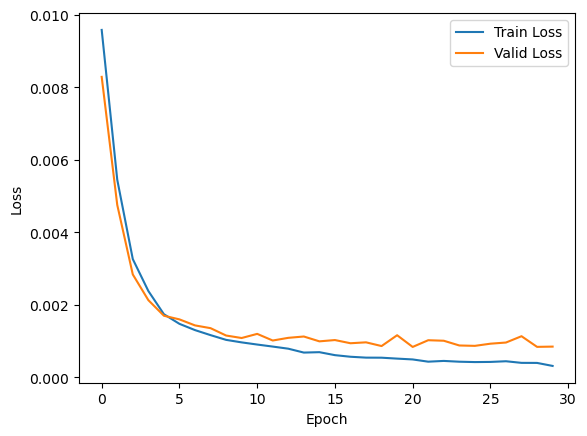

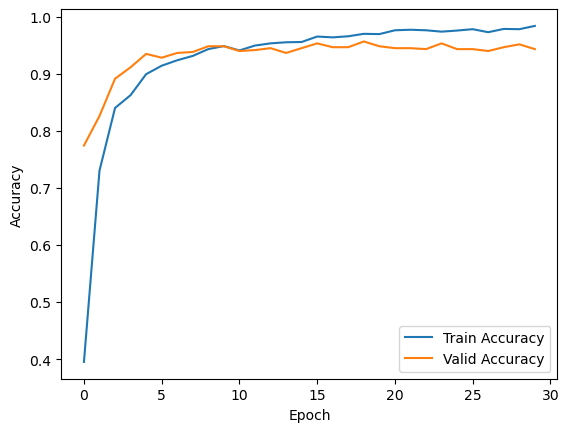

Most Misclassified Class: Chihuahua
Accuracy: 0.9401993355481728
False Positive: [0 2 0 5 2 1 1 3 0 0 0 0 1 0 3]
False Negative: [3 0 3 0 0 5 3 1 1 0 0 0 0 1 1]
True Positive: [13 19 22 20 16 22 23 15 13 20 20 18 22 22 18]
True Negative: [285 280 276 276 283 273 274 282 287 281 281 283 278 278 279]


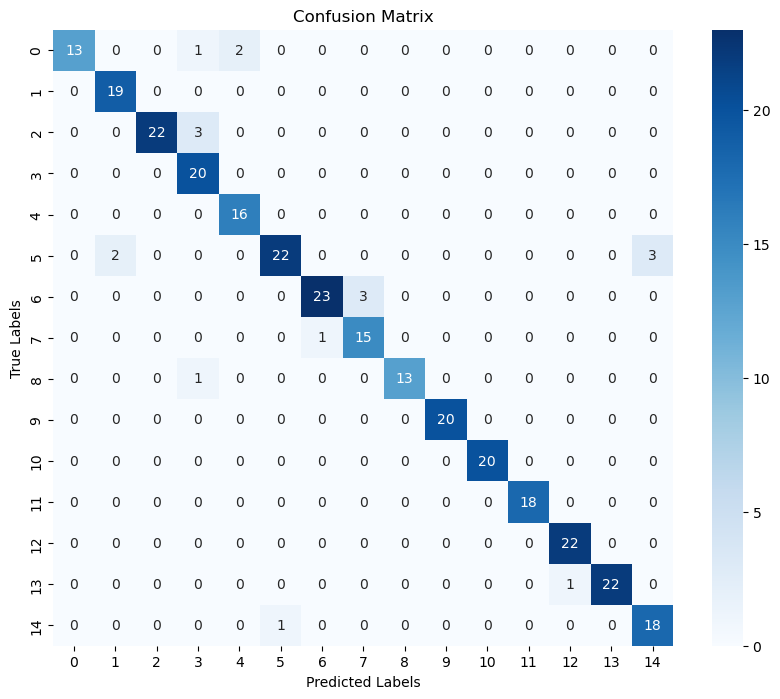

In [138]:
optimizer= "Adam"
num_epochs=30
dropout_rate=0.25
attention_model=resnet_train(optimizer,dropout_rate, num_epochs,train_dataset_loader,valid_dataset_loader,test_dataset_loader)

Most Misclassified Class: Chihuahua
Accuracy: 0.9401993355481728
False Positive: [0 2 0 5 2 1 1 3 0 0 0 0 1 0 3]
False Negative: [3 0 3 0 0 5 3 1 1 0 0 0 0 1 1]
True Positive: [13 19 22 20 16 22 23 15 13 20 20 18 22 22 18]
True Negative: [285 280 276 276 283 273 274 282 287 281 281 283 278 278 279]


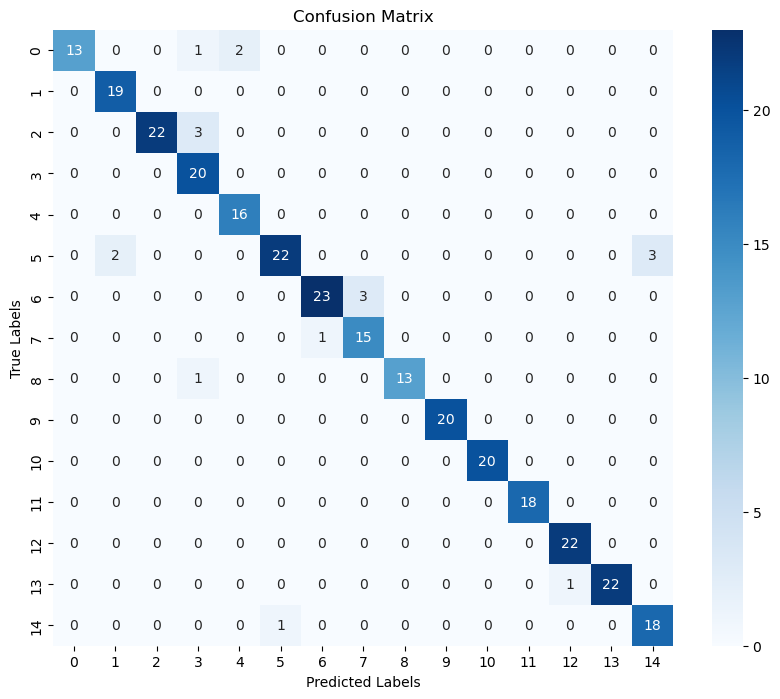

In [139]:
torch.save(model.state_dict(), "ly3_attentionresnet.pt")
create_confmatrix(attention_model,test_dataset_loader)

RESULTS

In this study, I conducted a series of experiments to train a multiclass image classification model. After preprocessing the dataset, I built the model from scratch, incorporating various regularization techniques such as Data Augmentation, Dropout, Early Stopping, and Learning Rate Scheduler. These techniques helped enhance the model's performance, demonstrating their effectiveness in improving classification accuracy.

To further leverage the capabilities of deep learning models, I performed fine-tuning on the ResNet-18 architecture. Fine-tuning involves taking a pre-trained model, in this case, ResNet-18 trained on the large-scale ImageNet dataset, and adapting it to the specific task at hand.

By initializing the model with the pre-trained weights, the network already possesses a strong foundation of knowledge about visual features and patterns learned from ImageNet. This pre-training gives the model a head start and allows it to capture generic features that are useful across a wide range of tasks.

During the fine-tuning process, I adjusted the weights of the pre-trained ResNet-18 model by continuing the training on my specific dataset. However, I focused the training on the latter layers of the network while keeping the initial layers frozen. This approach allows the model to learn more task-specific features and adapt to the nuances of my dataset, while still retaining the knowledge gained from the ImageNet pre-training.

By fine-tuning the ResNet-18 model, I effectively transferred the learned knowledge and experiences from the ImageNet dataset to my specific task. This technique has proven to be effective in many computer vision applications, as it allows models to benefit from the vast amount of labeled data available in the pre-training phase.

The results of the fine-tuning experiments demonstrated significant improvements in the model's performance. The model was able to leverage the pre-trained knowledge to achieve higher accuracy, showcasing the effectiveness of fine-tuning ResNet-18 for multiclass image classification tasks.

Overall, the fine-tuning process with ResNet-18 provided a powerful approach to adapt the model to my specific dataset and improve its performance, taking advantage of the knowledge gained from the pre-training phase on ImageNet.
